# Results R: How do sentiment, topic and socials correlate with each other and with demographic variables?

## Multilevel models with random intercepts and slopes

## Resources

In [11]:
# Get Packages & Libraries
library(brms)
#library(bayesplot)
library(rethinking)
library(tidyverse)
#library(tidybayes)
library(ggplot2)
library(ggridges)
#library(viridis)
#library(stargazer)
#library(cowplot)

In [12]:
# Functions
factorize <- function(df){ # Create a function
  for(i in which(sapply(df, class) == "character")) # that looks for variables with the character class 
      df[[i]] = as.factor(df[[i]]) # and converts them to factor (i.e., categorical) class
  return(df)
}

unfactorize <- function(df){ # Create a function
  for(i in which(sapply(df, class) == "factor")) # that looks for variables with the character class 
      df[[i]] = as.character(df[[i]]) # and converts them to factor (i.e., categorical) class
  return(df)
}

st <- function(x){
    (x-mean(x,na.rm=TRUE))/sd(x,na.rm=TRUE)
}

In [13]:
# View Data
#df1  <- read.csv("20240611_PhD_FinalData-Ltr.csv")
#df1[df1 == ''] <- NA #replace blank cells with NA
#df1 <- df1[-c(1:2)] #drop the index columns
#df1 <- factorize(df1)
#glimpse(df1)

In [14]:
# Get Data
# View Data
df2  <- read.csv("20240702_PhD_FinalData-DiaryChk.csv")
df2[df2 == ''] <- NA #replace blank cells with NA
#df2 <- df2[-c(1:2)] #drop the index columns
df2 <- factorize(df2)
glimpse(df2)

Rows: 1,023
Columns: 41
$ docid            <fct> D0002, D0002, D0002, D0002, D0002, D0002, D0002, D000…
$ docyear          <int> 1883, 1883, 1883, 1883, 1883, 1883, 1883, 1883, 1883,…
$ docmonth         <lgl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ authorName       <fct> Anne F. Richards, Anne F. Richards, Anne F. Richards,…
$ docauthorid      <fct> D0002, D0002, D0002, D0002, D0002, D0002, D0002, D000…
$ authorLocation   <fct> Australia, Australia, Australia, Australia, Australia…
$ authorGender     <fct> F, F, F, F, F, F, F, F, F, F, F, F, F, F, F, F, F, F,…
$ nationalOrigin   <fct> English, English, English, English, English, English,…
$ irish            <fct> False, False, False, False, False, False, False, Fals…
$ otherUK          <fct> True, True, True, True, True, True, True, True, True,…
$ relMin           <fct> False, False, False, False, False, False, False, Fals…
$ catholic         <fct> False, False, False, False, False, False, False, Fals…
$ otherChristian

In [15]:
# Get counts for topic number
table(as.factor(df2$topicNumber))

# Create new variable with topic labels that match pyLDAvis label numbers
df2$topicLabel <- as.character(df2$topicNumber)
df2$topicLabel[df2$topicLabel=="0"]  <- "01 Housework"
df2$topicLabel[df2$topicLabel=="1"]  <- "02 Places"
df2$topicLabel[df2$topicLabel=="2"]  <- "03 Business"
df2$topicLabel[df2$topicLabel=="3"]  <- "04 Girl Privilege"
df2$topicLabel[df2$topicLabel=="4"]  <- "05 Working Boy"
df2$topicLabel[df2$topicLabel=="5"]  <- "06 Weather"
df2$topicLabel[df2$topicLabel=="6"]  <- "07 People"
df2$topicLabel[df2$topicLabel=="7"]  <- "08 Politics"
df2$topicLabel[df2$topicLabel=="8"]  <- "09 Outback"
df2$topicLabel[df2$topicLabel=="9"]  <- "10 Home"
df2$topicLabel <- as.factor(df2$topicLabel)

# Check
df2 %>% 
select(topicNumber, topicLabel) %>% 
unique() %>% 
arrange(topicLabel)

table(df2$topicLabel)
sum(is.na(df2$topicLabel))


  0   1   2   3   4   5   6   7   8   9 
135 111 100 144 107  71  89 109  93  64 

topicNumber,topicLabel
<int>,<fct>
0,01 Housework
1,02 Places
2,03 Business
3,04 Girl Privilege
4,05 Working Boy
5,06 Weather
6,07 People
7,08 Politics
8,09 Outback



     01 Housework         02 Places       03 Business 04 Girl Privilege 
              135               111               100               144 
   05 Working Boy        06 Weather         07 People       08 Politics 
              107                71                89               109 
       09 Outback           10 Home 
               93                64 

[1] 0

In [16]:
# Socials Variable Prep
df2$mentsRate <- df2$mentsTot/df2$totalTokens # Higher rates = more social references
df2$fppAllRate <- df2$fppAll_Ct/df2$totalTokens # Higher rates = more inwardly focused
df2$fppSubRate <- df2$fppSub_Ct/df2$totalTokens # Higher rates = more inwardly focused

# Standardizing
df2$mentsRate.s <- st(df2$mentsRate)
df2$fppAllRate.s <- st(df2$fppAllRate)
df2$fppSubRate.s <- st(df2$fppSubRate)

# Summary
vars <- c("mentsRate", "fppAllRate", "fppSubRate", "mentsRate.s", "fppAllRate.s", "fppSubRate.s")
summary(df2[vars])

   mentsRate          fppAllRate        fppSubRate       mentsRate.s     
 Min.   :0.003704   Min.   :0.00000   Min.   :0.00000   Min.   :-2.1995  
 1st Qu.:0.027675   1st Qu.:0.01495   1st Qu.:0.01111   1st Qu.:-0.7165  
 Median :0.037415   Median :0.02465   Median :0.01845   Median :-0.1139  
 Mean   :0.039257   Mean   :0.02728   Mean   :0.02189   Mean   : 0.0000  
 3rd Qu.:0.048689   3rd Qu.:0.03521   3rd Qu.:0.02827   3rd Qu.: 0.5835  
 Max.   :0.111913   Max.   :0.09343   Max.   :0.07958   Max.   : 4.4950  
  fppAllRate.s      fppSubRate.s    
 Min.   :-1.6502   Min.   :-1.4532  
 1st Qu.:-0.7457   1st Qu.:-0.7157  
 Median :-0.1593   Median :-0.2286  
 Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.: 0.4797   3rd Qu.: 0.4231  
 Max.   : 4.0010   Max.   : 3.8293  

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-2.5421 -0.2412  0.1653  0.0000  0.4442  2.9282 

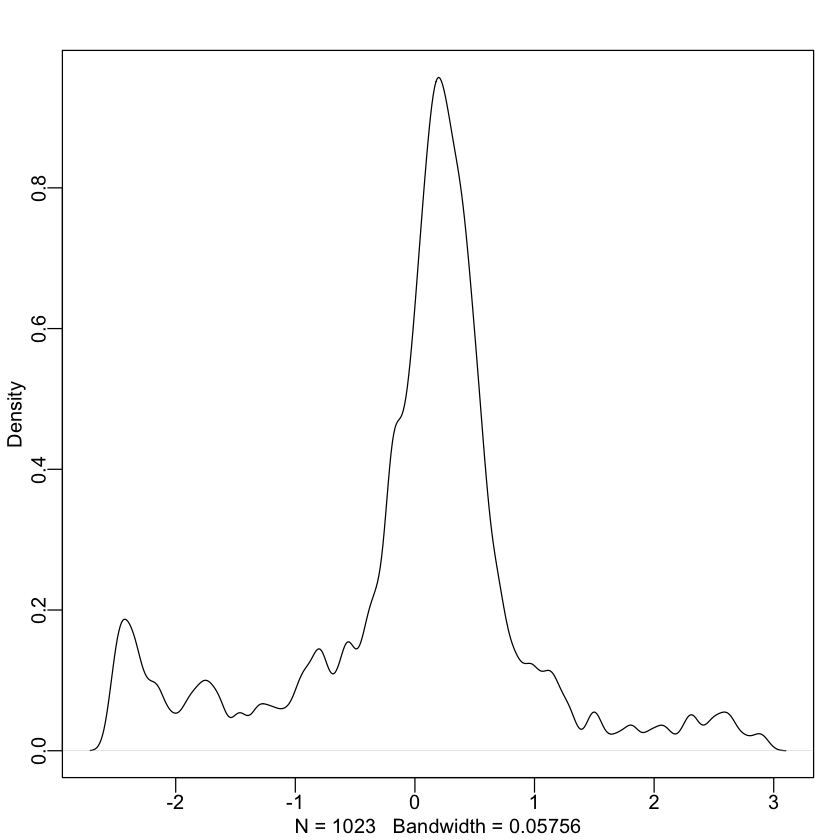

In [17]:
df2$scoreCom.s <- st(df2$scoreCom)
summary(df2$scoreCom.s)
dens(df2$scoreCom.s)

In [18]:
df2$authorGender <- relevel(df2$authorGender, "F")
levels(df2$authorGender)

[1] "F" "M"

## Sentiment ~ Topic

$$sentimentDiary_{ik} \sim Normal(\mu_{ik}, \sigma)$$
$$\mu_{ik} = \alpha_k$$
$$\alpha_k \sim Normal(\gamma, \phi) $$ 
$$\gamma \sim Normal(0,0.1) $$ 
$$\phi \sim Uniform(0,0.2) $$
$$\sigma \sim Uniform(0,0.4)$$ 


In [31]:
#Single Level Model
f2s <- readRDS("20240917_PhD_DiaChkSenTop_01.rds")
print(f2s)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scoreCom ~ topicLabel 
   Data: df2 (Number of observations: 1023) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Regression Coefficients:
                          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
Intercept                    -0.19      0.03    -0.25    -0.13 1.00      968
topicLabel02Places            0.16      0.04     0.08     0.25 1.00     1612
topicLabel03Business          0.20      0.05     0.11     0.29 1.00     2075
topicLabel04GirlPrivilege     0.22      0.04     0.14     0.30 1.00     1453
topicLabel05WorkingBoy        0.26      0.04     0.18     0.35 1.00     1667
topicLabel06Weather          -0.02      0.05    -0.11     0.08 1.00     1816
topicLabel07People            0.15      0.05     0.05     0.24 1.00     1656
topicLabel08Politics          0.16      0.04     0.07     0.24 1.00     1479
topicLabel09Outback           0.04  

In [27]:
#get_prior(formula= scoreCom ~ topicLabel, family = 'gaussian', data=df2)

In [32]:
#f2s <- brm(formula= scoreCom ~ topicLabel, 
#           family = 'gaussian', 
#           prior=c(set_prior("normal(0,.1)",class="Intercept"), 
#                   set_prior("uniform(0,.4)",class="sigma", ub = 0.4)), 
#           data=df2, 
#           chains=4, cores=4, iter=2000, warmup = 1000, seed = 4, 
#           file = "20240917_PhD_DiaChkSenTop_01", 
#           control=list(adapt_delta=.99))
#print(f2s)

In [28]:
#get_prior(formula= scoreCom ~ topicLabel + (1 | docauthorid), family = 'gaussian', data=df2)

In [33]:
#Multi Random Intercepts
f2mi <- readRDS("20240917_PhD_LtrChkSenTop_02i.rds")
print(f2mi)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scoreCom ~ topicLabel + (1 | docauthorid) 
   Data: df2 (Number of observations: 1023) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Multilevel Hyperparameters:
~docauthorid (Number of levels: 4) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.12      0.05     0.02     0.20 1.00     1982     1822

Regression Coefficients:
                          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
Intercept                    -0.09      0.08    -0.24     0.08 1.00     1572
topicLabel02Places            0.11      0.12    -0.14     0.34 1.00     1415
topicLabel03Business          0.14      0.12    -0.12     0.38 1.00     1407
topicLabel04GirlPrivilege     0.11      0.09    -0.06     0.28 1.00     2315
topicLabel05WorkingBoy        0.06      0.12    -0.19     0.29 1.00     1954
topicLabel06Weather          -0.01

In [34]:
# Multi Random Intercepts

#f2mi <- brm(
#    formula= scoreCom ~ topicLabel + (1 | docauthorid),
#    family = 'gaussian',
#    prior=c(set_prior("normal(0,0.1)",class="Intercept"),
#            set_prior("uniform(0,0.2)",class="sd", ub=0.2),
#            set_prior("uniform(0,0.4)",class="sigma", ub=0.4)),
#    data=df2,
#    chains=4, cores=4, iter=2000, warmup = 1000, seed = 4,
#    file = "20240917_PhD_LtrChkSenTop_02i",
#    control=list(adapt_delta=.99)
#)
#print(f2mi)

In [39]:
#get_prior(formula= scoreCom ~ topicLabel + (1 + topicLabel | docauthorid), family = 'gaussian', data=df2)

In [37]:
#Multi Random Intercepts
f2mis <- readRDS("20240917_PhD_LtrChkSenTop_02is.rds")
print(f2mis)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scoreCom ~ topicLabel + (1 + topicLabel | docauthorid) 
   Data: df2 (Number of observations: 1023) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Multilevel Hyperparameters:
~docauthorid (Number of levels: 4) 
                                                      Estimate Est.Error
sd(Intercept)                                             0.11      0.05
sd(topicLabel02Places)                                    0.10      0.06
sd(topicLabel03Business)                                  0.10      0.06
sd(topicLabel04GirlPrivilege)                             0.11      0.06
sd(topicLabel05WorkingBoy)                                0.09      0.06
sd(topicLabel06Weather)                                   0.09      0.06
sd(topicLabel07People)                                    0.10      0.06
sd(topicLabel08Politics)                                  0.10      0.06


In [38]:
# Random Intercepts & Random Slopes

#f2mis <- brm(
#    formula= scoreCom ~ topicLabel + (1 + topicLabel | docauthorid),
#    family = 'gaussian',
#    prior=c(set_prior("normal(0,0.1)",class="Intercept"),
#            set_prior("uniform(0,0.2)",class="sd", ub=0.2),
#            set_prior("uniform(0,0.4)",class="sigma", ub=0.4),
#            set_prior("lkj(2)", class = "cor")),
#    data=df2,
#    chains=4, cores=4, iter=2000, warmup = 1000, seed = 4,
#    file = "20240917_PhD_LtrChkSenTop_02is",
#    control=list(adapt_delta=.99)
#)
#print(f2mis)

In [40]:
# Model Comparison

f2s <- add_criterion(f2s, "waic")
f2mi <- add_criterion(f2mi, "waic")
f2mis <- add_criterion(f2mis, "waic")

w <- loo_compare(f2s, f2mi, f2mis, criterion = "waic")

print(w, simplify = F)

Automatically saving the model object in '20240917_PhD_DiaChkSenTop_01.rds'

Automatically saving the model object in '20240917_PhD_LtrChkSenTop_02i.rds'

Warning message:
“
2 (0.2%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Automatically saving the model object in '20240917_PhD_LtrChkSenTop_02is.rds'



      elpd_diff se_diff elpd_waic se_elpd_waic p_waic se_p_waic waic   se_waic
f2mis    0.0       0.0  -369.4      31.3         15.4    1.3     738.8   62.7 
f2mi    -0.6       1.2  -370.0      31.3         14.3    1.0     740.0   62.5 
f2s     -2.6       1.9  -372.0      31.0         12.8    0.9     744.0   62.0 


In [114]:
#post <- as_draws_df(f2s)
#mcmc_intervals(post[, 1:11], point_est = "mean") + theme_bw() + theme(axis.text.y = element_text(hjust = 0), axis.ticks.y = element_blank(), panel.grid = element_blank())

Picking joint bandwidth of 0.00595



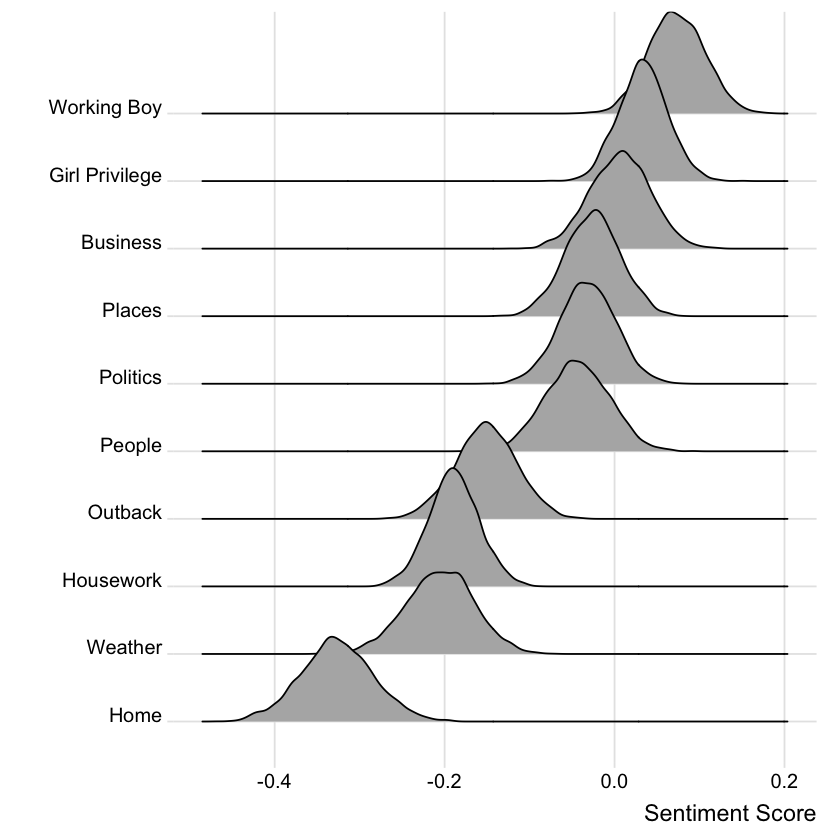

In [41]:
nd <- distinct(df2, topicLabel)


f <- data.frame(fitted(f2s,
         newdata = nd,
         re_formula = NA,
         probs = c(.1, .90), 
         summary = F))

colnames(f) <- c("Outback", 
                 "Weather", 
                 "Housework", 
                 "People", 
                 "Home", 
                 "Girl Privilege", 
                 "Working Boy", 
                 "Places",
                 "Politics",
                 "Business")

f <- f %>%                                   
  gather(variable, value)  

# Plot
ggplot(f, aes(x = value, y = reorder(variable, value))) +
  geom_density_ridges() +
  theme_ridges() + 
  theme(legend.position = "none") + 
xlab("Sentiment Score") +
    ylab("")

#ggsave("20240714_PhD_DiaChkSentTop.png")

Picking joint bandwidth of 0.0154



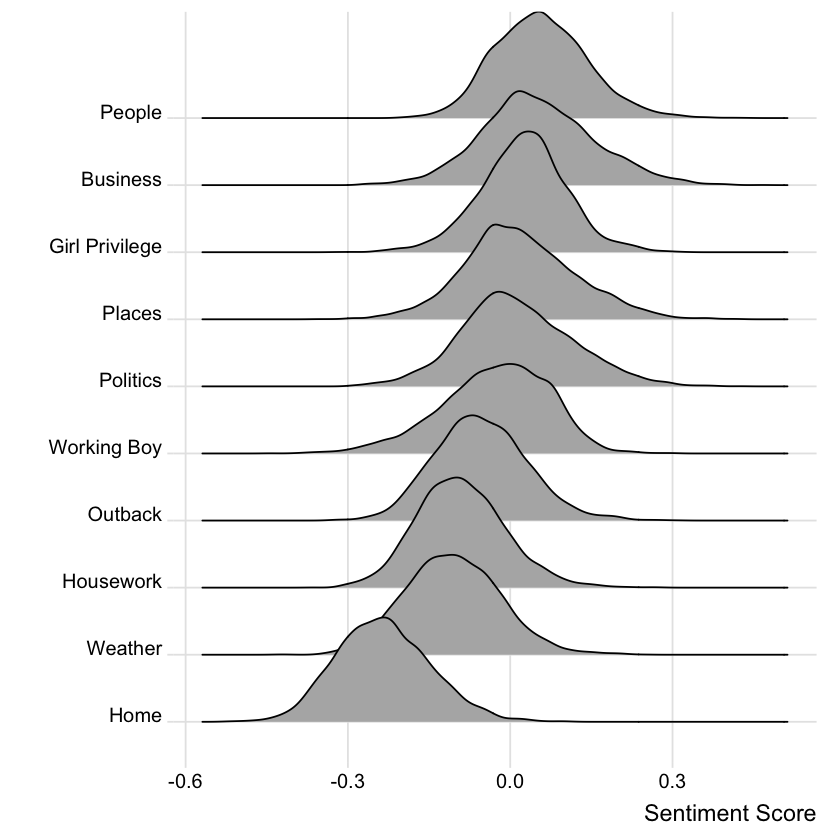

In [42]:
nd <- distinct(df2, topicLabel)


f <- data.frame(fitted(f2mi,
         newdata = nd,
         re_formula = NA,
         probs = c(.1, .90), 
         summary = F))

colnames(f) <- c("Outback", 
                 "Weather", 
                 "Housework", 
                 "People", 
                 "Home", 
                 "Girl Privilege", 
                 "Working Boy", 
                 "Places",
                 "Politics",
                 "Business")

f <- f %>%                                   
  gather(variable, value)  

# Plot
ggplot(f, aes(x = value, y = reorder(variable, value))) +
  geom_density_ridges() +
  theme_ridges() + 
  theme(legend.position = "none") + 
xlab("Sentiment Score") +
    ylab("")

#ggsave("20240714_PhD_DiaChkSentTop.png")

Picking joint bandwidth of 0.0213



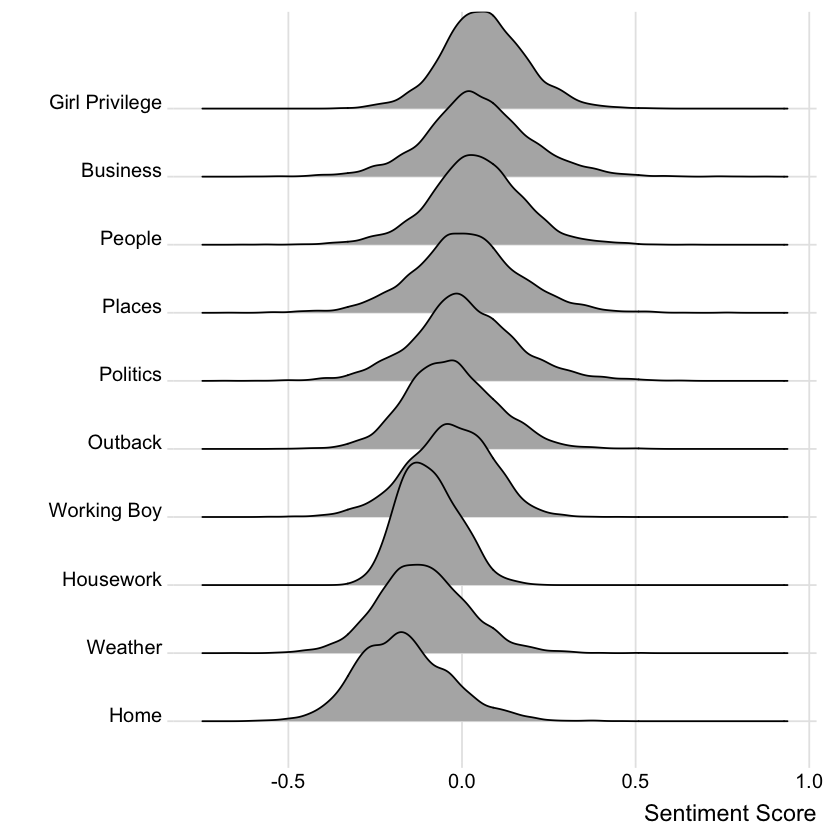

In [43]:
nd <- distinct(df2, topicLabel)


f <- data.frame(fitted(f2mis,
         newdata = nd,
         re_formula = NA,
         probs = c(.1, .90), 
         summary = F))

colnames(f) <- c("Outback", 
                 "Weather", 
                 "Housework", 
                 "People", 
                 "Home", 
                 "Girl Privilege", 
                 "Working Boy", 
                 "Places",
                 "Politics",
                 "Business")

f <- f %>%                                   
  gather(variable, value)  

# Plot
ggplot(f, aes(x = value, y = reorder(variable, value))) +
  geom_density_ridges() +
  theme_ridges() + 
  theme(legend.position = "none") + 
xlab("Sentiment Score") +
    ylab("")

#ggsave("20240714_PhD_DiaChkSentTop.png")

In [44]:
nd <- distinct(df2, topicLabel)

fitted(f2mis, newdata = nd, probs = c(.1,.9), re_formula = NA) %>%
as_tibble() %>%
bind_cols(nd) %>% 
arrange(desc(Estimate))

Estimate,Est.Error,Q10,Q90,topicLabel
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.06328977,0.11990607,-0.08094453,0.214562657,04 Girl Privilege
0.04581324,0.15457305,-0.13836365,0.236739879,03 Business
0.03834378,0.13712847,-0.12846566,0.204017208,07 People
0.01219396,0.15589759,-0.17437287,0.207591293,02 Places
0.00668258,0.15306171,-0.18009954,0.197680876,08 Politics
-0.03000825,0.13095921,-0.18777185,0.141665702,09 Outback
-0.03652343,0.12187906,-0.19195688,0.113735449,05 Working Boy
-0.09537341,0.08656389,-0.20026746,0.023065572,01 Housework
-0.11346987,0.12926855,-0.27153249,0.049832162,06 Weather


## Sentiment ~ Socials

Here I compare random intercept versus random intercept + random slope models. First, the random intercept only model.

$$sentimentLetter_{ik} \sim Norm(\mu_{ik}, \sigma)$$

$$\mu_{ik} = \beta_{0k} + \beta_{1}mentsRate_i$$

$$\beta_{0k} = \gamma_{0} + \eta_{0k}$$
$$\eta_{0k} \sim Norm(0,\phi_{0})$$
$$\beta_{1} \sim Norm(0,3)$$
$$\sigma \sim Unif(0,10)$$

In [46]:
#get_prior(formula= scoreCom ~ mentsRate + (1 | docauthorid), family = 'gaussian', data=df2)

prior,class,coef,group,resp,dpar,nlpar,lb,ub,source
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
,b,,,,,,,,default
,b,mentsRate.s,,,,,,,default
"student_t(3, 0, 2.5)",Intercept,,,,,,,,default
"student_t(3, 0, 2.5)",sd,,,,,,0,,default
,sd,,docauthorid,,,,,,default
,sd,Intercept,docauthorid,,,,,,default
"student_t(3, 0, 2.5)",sigma,,,,,,0,,default


In [75]:
# Random Intercepts

f5mi <- readRDS("20240917_PhD_DiaChkSenMents_02i.rds")
print(f5mi)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scoreCom ~ mentsRate + (1 | docauthorid) 
   Data: df2 (Number of observations: 1023) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Multilevel Hyperparameters:
~docauthorid (Number of levels: 4) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.13      0.04     0.06     0.19 1.01     1353     1610

Regression Coefficients:
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept    -0.02      0.06    -0.14     0.10 1.01     1298     1711
mentsRate     0.10      0.77    -1.38     1.65 1.00     2728     2242

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.35      0.01     0.33     0.37 1.00     2547     1998

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures,

In [74]:
# Random Intercepts

f5mi <- brm(
    formula= scoreCom ~ mentsRate + (1 | docauthorid),
    family = 'gaussian',
    prior=c(set_prior("normal(0,0.1)",class="Intercept"),
            set_prior("uniform(0,0.2)",class="sd", ub=0.2),
            set_prior("uniform(0,0.4)",class="sigma", ub=0.4)),
    data=df2,
    chains=4, cores=4, iter=2000, warmup = 1000, seed = 4,
    file = "20240917_PhD_DiaChkSenMents_02i",
    control=list(adapt_delta=.99)
)
print(f5mi)

Compiling Stan program...

Start sampling

Found more than one class "stanfit" in cache; using the first, from namespace 'rstan'

Also defined by ‘rethinking’

Found more than one class "stanfit" in cache; using the first, from namespace 'rstan'

Also defined by ‘rethinking’

Found more than one class "stanfit" in cache; using the first, from namespace 'rstan'

Also defined by ‘rethinking’

Found more than one class "stanfit" in cache; using the first, from namespace 'rstan'

Also defined by ‘rethinking’



 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scoreCom ~ mentsRate + (1 | docauthorid) 
   Data: df2 (Number of observations: 1023) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Multilevel Hyperparameters:
~docauthorid (Number of levels: 4) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.13      0.04     0.06     0.19 1.01     1353     1610

Regression Coefficients:
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept    -0.02      0.06    -0.14     0.10 1.01     1298     1711
mentsRate     0.10      0.77    -1.38     1.65 1.00     2728     2242

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.35      0.01     0.33     0.37 1.00     2547     1998

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures,

In [67]:
# Random Intercepts and Random Slopes

f5mis <- readRDS("20240917_PhD_DiaChkSenMents_02is.rds")
print(f5mis)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scoreCom ~ mentsRate.s + (1 + mentsRate.s | docauthorid) 
   Data: df2 (Number of observations: 1023) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Multilevel Hyperparameters:
~docauthorid (Number of levels: 4) 
                           Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sd(Intercept)                  0.13      0.04     0.06     0.20 1.00     1840
sd(mentsRate.s)                0.03      0.03     0.00     0.13 1.00     1311
cor(Intercept,mentsRate.s)     0.00      0.43    -0.79     0.80 1.00     3317
                           Tail_ESS
sd(Intercept)                  1715
sd(mentsRate.s)                1540
cor(Intercept,mentsRate.s)     2232

Regression Coefficients:
            Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept      -0.02      0.05    -0.13     0.09 1.00     1464     1972
mentsRate.s     0.00      0.0

In [52]:
# Random Intercepts & Random Slopes

f5mis <- brm(
    formula= scoreCom ~ mentsRate + (1 + mentsRate | docauthorid),
    family = 'gaussian',
    prior=c(set_prior("normal(0,0.1)",class="Intercept"),
            set_prior("uniform(0,0.2)",class="sd", ub=0.2),
            set_prior("uniform(0,0.4)",class="sigma", ub=0.4),
            set_prior("lkj(2)", class = "cor")),
    data=df2,
    chains=4, cores=4, iter=2000, warmup = 1000, seed = 4,
    file = "20240917_PhD_DiaChkSenMents_02is",
    control=list(adapt_delta=.99)
)

print(f5mis)

In [53]:
# Model Comparison

f5mi <- add_criterion(f5mi, "waic")
f5mis <- add_criterion(f5mis, "waic")

w <- loo_compare(f5mi, f5mis, criterion = "waic")

print(w, simplify = F)

Automatically saving the model object in '20240917_PhD_DiaChkSenMents_02i.rds'

Automatically saving the model object in '20240917_PhD_DiaChkSenMents_02is.rds'



      elpd_diff se_diff elpd_waic se_elpd_waic p_waic se_p_waic waic   se_waic
f5mi     0.0       0.0  -376.7      31.1          5.4    0.4     753.4   62.1 
f5mis   -0.8       0.2  -377.5      31.0          6.2    0.4     755.0   62.0 


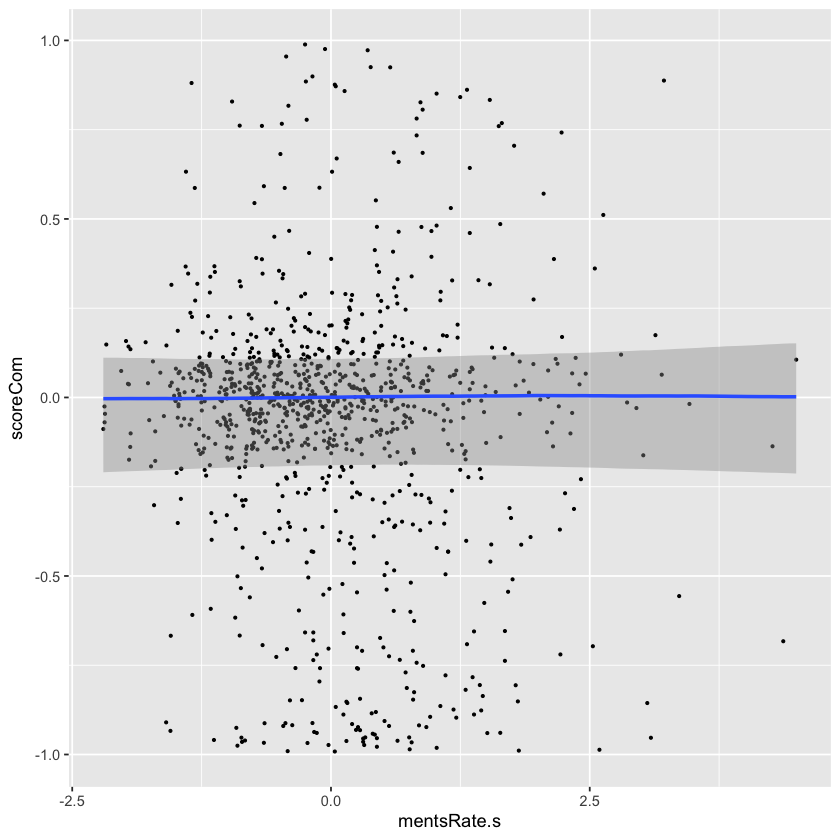

In [68]:
plot(conditional_effects(f5mi, prob=.90, re_formula=NULL), points=T, point_args = list(size = .5))
#dev.copy(png,'20240917_PhD_DiaChkSenMenIntFix.png')
#dev.off()

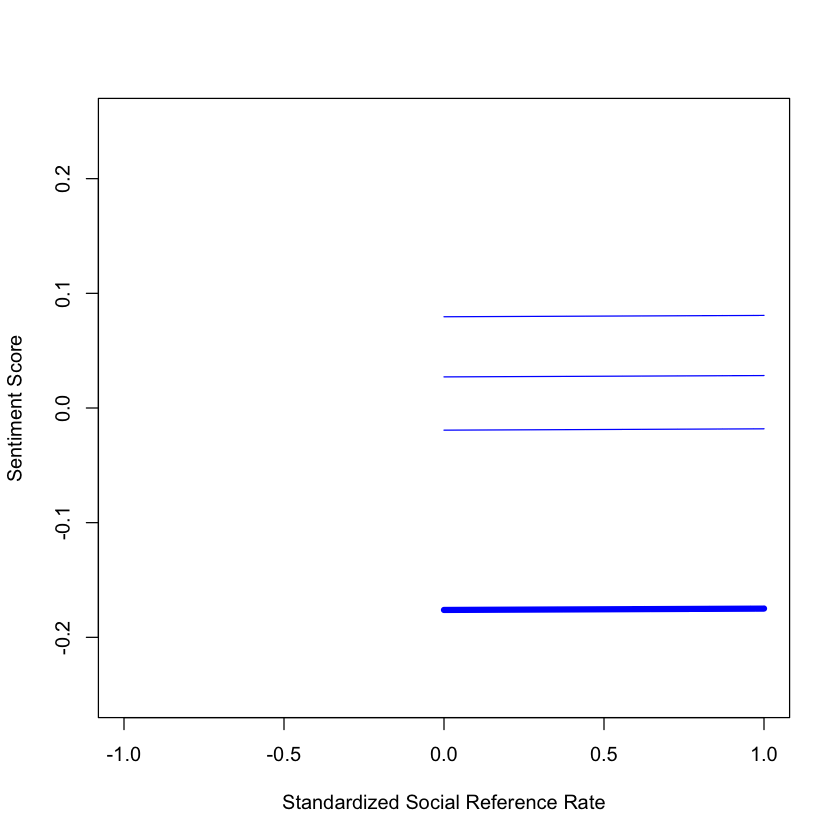

In [72]:
# Like above but with different colours

re2 <- ranef(f5mis)
fe2 <- fixef(f5mis)

fixers <- data.frame(fe2)
randoms <- data.frame((re2)[1])

data1 <- randoms                                          
data1$row_names <- row.names(data1)
data1$row_names[data1$row_names=="D0002"] <- "Housewife"
data1$row_names[data1$row_names=="D0003"] <- "Labourer"
data1$row_names[data1$row_names=="D0007"] <- "Businessman"
data1$row_names[data1$row_names=="D0009"] <- "Lady"

aHW  <- data1$docauthorid.Estimate.Intercept[1] + fixers[1,1] #Housewife intercept
bHW  <- fixers[2,1] #Housewife mentions rate

aBL  <- data1$docauthorid.Estimate.Intercept[2] + fixers[1,1] #Labourer intercept
bBL  <- fixers[2,1] #Labourer mentions rate

aBM  <- data1$docauthorid.Estimate.Intercept[3] + fixers[1,1] #Businessman intercept
bBM  <- fixers[2,1] #Businessman mentions rate

aGP  <- data1$docauthorid.Estimate.Intercept[4] + fixers[1,1] #Lady intercept
bGP <- fixers[2,1] #Lady mentions rate

alphas <- c(aHW,aBL,aBM,aGP)
betas <- c(bHW,bBL,bBM,bGP)

plot(NA,xlim=c(0,1),ylim=c(-0.25, .25), xlab = "Social Reference Rate", ylab = "Sentiment Score")
{lines(c(0,1),c(alphas[1],alphas[1] + 1*betas[1]), lty = 1, lwd = 5, col='blue')} # Housewife
{lines(c(0,1),c(alphas[2],alphas[2] + 1*betas[2]), lty = 1, lwd = 1, col = "blue")} # Labourer
{lines(c(0,1),c(alphas[3],alphas[3] + 1*betas[3]), lty = 1, lwd = 1, col = "blue")} # Businessman
{lines(c(0,1),c(alphas[4],alphas[4] + 1*betas[4]), lty = 1, lwd = 1, col = "blue")} # Lady

#dev.copy(png,'20240814_PhD_DiaChkSenMenIntRan.png')
#dev.off()

Now the random slopes model using a joint (rather than independent) distribution per 20190312_PM_Slides (p. 25).

<p>I include the notation style used by McElreath and Kurtz followed by the slightly different approach used by the professor who taught me Bayesian statistics (Peter McMahon). The main differences are in how the random intercepts are specified, as described in 20190228_PM_Slides (pg. 5). </p>
    <ul><li>representation of intercept and slope
        <ul><li>McElreath / Kurtz: $\alpha$ and $\beta$</li>
            <li>McMahon: $\beta_0$ and $\beta_1$</li></ul></li>
        <li>representation of grouping index
        <ul><li>McElreath / Kurtz: $_{writer}[i]$</li>
            <li>McMahon: $_k$</li></ul></li>
        <li>representation of the covariance matrix
        <ul><li>McElreath / Kurtz: S and $\Sigma$, respectively</li>
            <li>McMahon: $\Phi$</li></ul></li>
        <li>representation of variance (standard deviation) for intercepts and slopes
        <ul><li>McElreath / Kurtz: $\sigma_\alpha$ and $\sigma_\beta$</li>
            <li>McMahon: $\phi_0$ and $\phi_1$ </li></ul></li> 
        <li>class-specific intercepts and slopes (to add to average)
        <ul><li>McElreath / Kurtz: Rolled into $\alpha_{writer}$ and $\beta_{writer}$</li>
            <li>McMahon: $\eta_0$ and $\eta_1$ </li></ul></li> 
        <li>average intercept and slope
        <ul><li>McElreath / Kurtz: Rolled into $\alpha_{writer}$ and $\beta_{writer}$</li>
            <li>McMahon: $\gamma_{00}$ and $\gamma_{10}$ </li></ul></li> 
        <li>mean of average class level intercept 
        <ul><li>McElreath / Kurtz: Rolled into $\alpha_{writer}$ and $\beta_{writer}$</li>
            <li>McMahon: $0$ </li></ul></li> 
</ul>
            

<h4>McElreath / Kurz Notation (see 14.1.3)</h4>

$$sentimentLetter_{i} \sim Normal(\mu_{i}, \sigma)$$

$$\mu_{i} = \alpha_{writer[i]} + \beta_{writer[i]}socialMetric_i$$

$$\left[ \begin{split} \alpha_{writer} \\ \beta_{writer} \end{split} \right] \sim MVNormal \left( \left[ \begin{split} \alpha \\ \beta \end{split}\right], \Sigma \right)$$

$$ \Sigma = \left[ \begin{split} \sigma_{\alpha} \quad 0 \\ 0 \quad \sigma_{\beta} \end{split} \right] R \left[ \begin{split} \sigma_{\alpha} \quad 0 \\ 0 \quad \sigma_{\beta} \end{split} \right]$$

$$\alpha \sim Normal(0,3)$$
$$\beta \sim Normal(0,.5)$$
$$\sigma \sim Exponential(1)$$
$$\sigma_{\alpha} \sim Exponential(1)$$
$$\sigma_{\beta} \sim Exponential(1)$$
$$R \sim LKJcorr(2)$$

<p>Note that McElreath uses "S" instead of $\Sigma$.</p>

<h4>McMahon Notation (see 20190314_PM_Code.htm)</h4>

$$sentimentLetter_{ik} \sim Norm(\mu_{ik}, \sigma)$$

$$\mu_{ik} = \beta_{0k} + \beta_{1k}socialMetric_i$$

$$\beta_{0k} = \gamma_{00} + \eta_{0k}$$
$$\beta_{1k} = \gamma_{10} + \eta_{1k}$$
$$\left[ \begin{split}\eta_{0k} \\ \eta_{1k} \end{split} \right] \sim MVNorm\left(\left[ \begin{split}0 \\ 0 \end{split} \right], \Phi\right)$$
$$\Phi = \left[ \begin{split} \phi_0 \quad 0 \\ 0 \quad \phi_1 \end{split} \right] R \left[ \begin{split} \phi_0 \quad 0 \\ 0 \quad \phi_1 \end{split} \right]$$
$$\sigma \sim Exp(1)$$
$$\gamma_{00} \sim Norm(0,3)$$
$$\gamma_{10} \sim Norm(0,.5)$$
$$\phi_0 \sim Exp(1)$$
$$\phi_1 \sim Exp(1)$$
$$R \sim LKJ(2,2)$$

In [63]:
# Random Intercepts and Random Slopes

f5mis <- readRDS("20240730_PhD_DiaChkSenMents_02s.rds")
print(f5mis)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scoreCom ~ 1 + mentsRate + (1 + mentsRate | docauthorid) 
   Data: df2 (Number of observations: 1023) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Multilevel Hyperparameters:
~docauthorid (Number of levels: 4) 
                         Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sd(Intercept)                0.20      0.15     0.06     0.60 1.00     1122
sd(mentsRate)                0.60      0.55     0.02     2.10 1.00     3207
cor(Intercept,mentsRate)    -0.01      0.44    -0.81     0.82 1.00     3586
                         Tail_ESS
sd(Intercept)                1203
sd(mentsRate)                2268
cor(Intercept,mentsRate)     2059

Regression Coefficients:
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept    -0.03      0.11    -0.27     0.19 1.00     1243     1370
mentsRate     0.05      0.43    -0.82     0.89 1.

In [251]:
f5.1m <- brm(
      formula = scoreCom ~ 1 + mentsRate + (1 + mentsRate | docauthorid),
      family = gaussian,
      prior = c(
          set_prior("normal(0,3)", class = "Intercept"), # gamma_00
          set_prior("normal(0,.5)", class = "b"), # coefficient
          set_prior("exponential(1)", class = "sd"), # phi_0, phi_1, phi_2, phi_3
          set_prior("exponential(1)", class = "sigma"), # sigma
          set_prior("lkj(2)", class = "cor") # R
      ),
      data = df2, 
      chains = 4, cores = 4, iter = 2000, warmup = 1000, seed = 4,
      file = "20240730_PhD_DiaChkSenMents_02s",
      control=list(adapt_delta=.99)
)

print(f5.1m)

Compiling Stan program...

Start sampling

Found more than one class "stanfit" in cache; using the first, from namespace 'rstan'

Also defined by ‘rethinking’

Found more than one class "stanfit" in cache; using the first, from namespace 'rstan'

Also defined by ‘rethinking’

Found more than one class "stanfit" in cache; using the first, from namespace 'rstan'

Also defined by ‘rethinking’

Found more than one class "stanfit" in cache; using the first, from namespace 'rstan'

Also defined by ‘rethinking’



In [64]:
f5.1m <- readRDS("20240730_PhD_DiaChkSenMents_02s.rds")

In [65]:
print(f5.1m)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scoreCom ~ 1 + mentsRate + (1 + mentsRate | docauthorid) 
   Data: df2 (Number of observations: 1023) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Multilevel Hyperparameters:
~docauthorid (Number of levels: 4) 
                         Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sd(Intercept)                0.20      0.15     0.06     0.60 1.00     1122
sd(mentsRate)                0.60      0.55     0.02     2.10 1.00     3207
cor(Intercept,mentsRate)    -0.01      0.44    -0.81     0.82 1.00     3586
                         Tail_ESS
sd(Intercept)                1203
sd(mentsRate)                2268
cor(Intercept,mentsRate)     2059

Regression Coefficients:
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept    -0.03      0.11    -0.27     0.19 1.00     1243     1370
mentsRate     0.05      0.43    -0.82     0.89 1.

In [253]:
f1m_i <- add_criterion(f5m, "waic")
f1m_is <- add_criterion(f5.1m, "waic")

w <- loo_compare(f1m_i, f1m_is, criterion = "waic")

print(w, simplify = F)

Automatically saving the model object in '20240702_PhD_DiaChkSenMents_02.rds'

Automatically saving the model object in '20240730_PhD_DiaChkSenMents_02s.rds'



       elpd_diff se_diff elpd_waic se_elpd_waic p_waic se_p_waic waic   se_waic
f1m_is    0.0       0.0  -376.4      31.1          5.2    0.4     752.8   62.2 
f1m_i    -0.3       0.2  -376.7      31.1          5.5    0.4     753.5   62.1 


quartz_off_screen 
                3

pdf 
  2

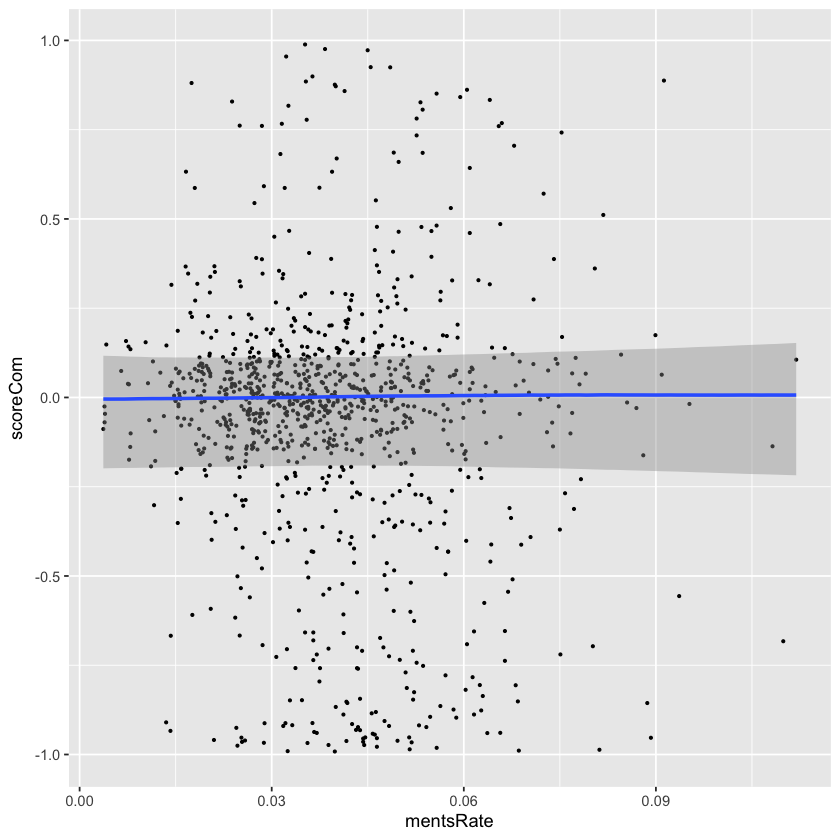

In [112]:
plot(conditional_effects(f5.1m, prob=.90, re_formula=NULL), points=T, point_args = list(size = .5))
dev.copy(png,'20240814_PhD_DiaChkSenMenIntSloFix.png')
dev.off()

In [66]:
#re2 <- ranef(f5.1m)
#fe2 <- fixef(f5.1m)

# get the intercept for each student (random plus fixed effect)
#a <- re2[[1]][,"Estimate","Intercept"] + fe2["Intercept","Estimate"]
# get the slope for each student (random plus fixed effect)
#b <- re2[[1]][,"Estimate","mentsRate"] + fe2["mentsRate","Estimate"]

# take all writers
#s <- sample(length(a),4)
# figure out a good vertical range
#ylim <- range(a[s],(a+1*(b))[s])
# plot the individual lines
#plot(NA,xlim=c(0,1),ylim=ylim)
#for(i in s){lines(c(0,1),c(a[i],a[i] + 1*b[i]),col='#00000055')}

quartz_off_screen 
                3

pdf 
  2

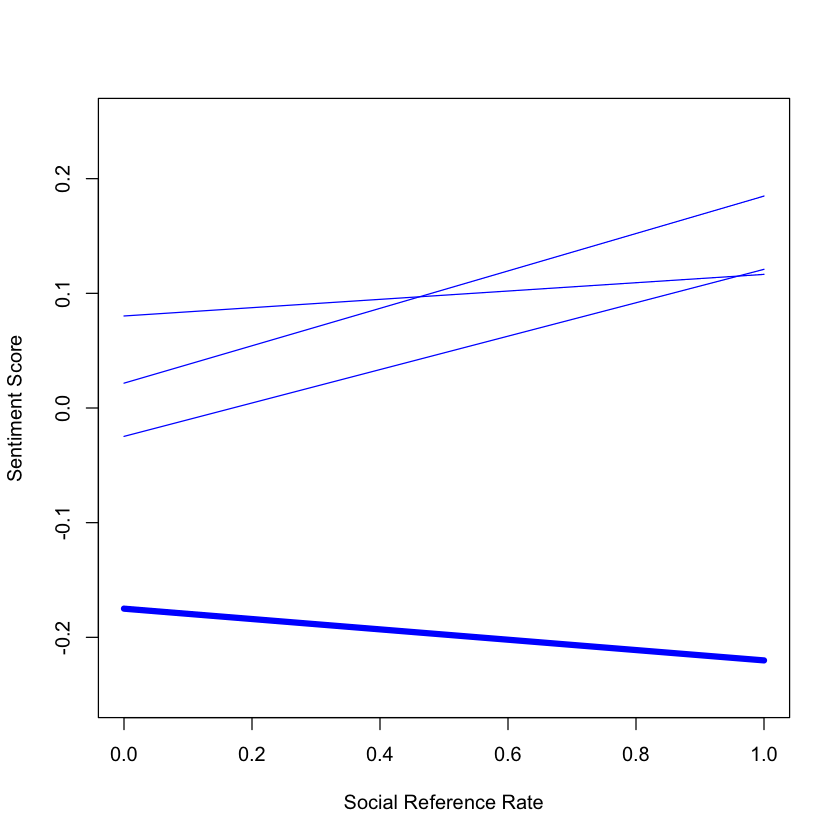

In [66]:
# Like above but with different colours

re2 <- ranef(f5.1m)
fe2 <- fixef(f5.1m)

fixers <- data.frame(fe2)
randoms <- data.frame((re2)[1])

data1 <- randoms                                          
data1$row_names <- row.names(data1)
data1$row_names[data1$row_names=="D0002"] <- "Housewife"
data1$row_names[data1$row_names=="D0003"] <- "Labourer"
data1$row_names[data1$row_names=="D0007"] <- "Businessman"
data1$row_names[data1$row_names=="D0009"] <- "Lady"

aHW  <- data1$docauthorid.Estimate.Intercept[1] + fixers[1,1] #Housewife intercept
bHW  <- data1$docauthorid.Estimate.mentsRate[1] + fixers[2,1] #Housewife mentions rate

aBL  <- data1$docauthorid.Estimate.Intercept[2] + fixers[1,1] #Labourer intercept
bBL  <- data1$docauthorid.Estimate.mentsRate[2] + fixers[2,1] #Labourer mentions rate

aBM  <- data1$docauthorid.Estimate.Intercept[3] + fixers[1,1] #Businessman intercept
bBM  <- data1$docauthorid.Estimate.mentsRate[3] + fixers[2,1] #Businessman mentions rate

aGP  <- data1$docauthorid.Estimate.Intercept[4] + fixers[1,1] #Lady intercept
bGP <- data1$docauthorid.Estimate.mentsRate[4] + fixers[2,1] #Lady mentions rate

alphas <- c(aHW,aBL,aBM,aGP)
betas <- c(bHW,bBL,bBM,bGP)

plot(NA,xlim=c(0,1),ylim=c(-0.25, .25), xlab = "Social Reference Rate", ylab = "Sentiment Score")
{lines(c(0,1),c(alphas[1],alphas[1] + 1*betas[1]), lty = 1, lwd = 5, col='blue')} # Housewife
{lines(c(0,1),c(alphas[2],alphas[2] + 1*betas[2]), lty = 1, lwd = 1, col = "blue")} # Labourer
{lines(c(0,1),c(alphas[3],alphas[3] + 1*betas[3]), lty = 1, lwd = 1, col = "blue")} # Businessman
{lines(c(0,1),c(alphas[4],alphas[4] + 1*betas[4]), lty = 1, lwd = 1, col = "blue")} # Lady

dev.copy(png,'20240814_PhD_DiaChkSenMenIntSloRan.png')
dev.off()

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-2.5421 -0.2412  0.1653  0.0000  0.4442  2.9282 

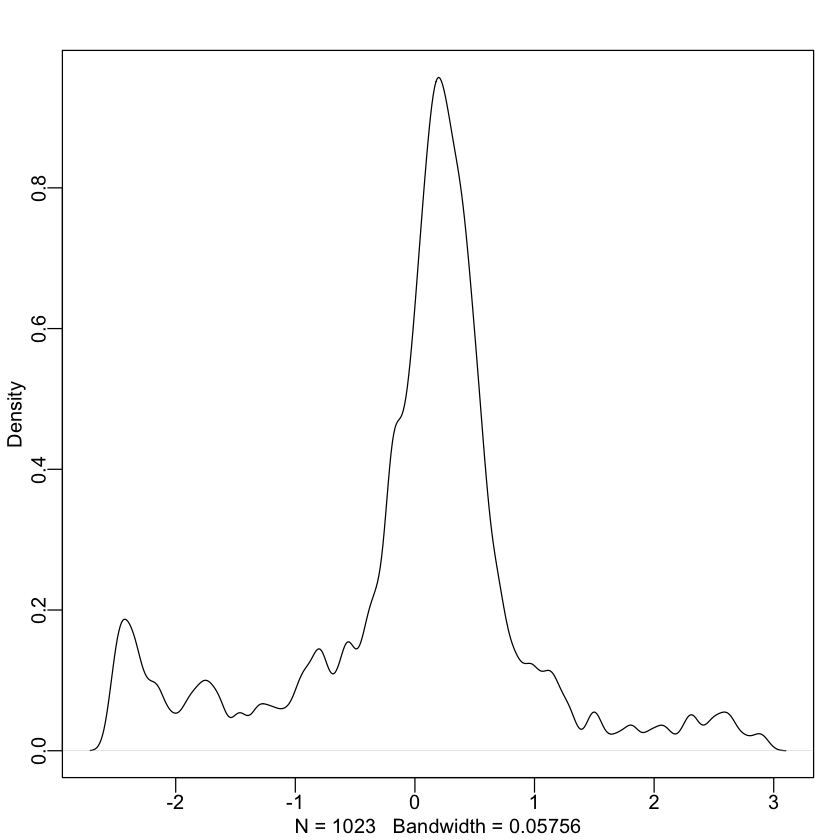

In [23]:
df2$scoreCom.s <- st(df2$scoreCom)
summary(df2$scoreCom.s)
dens(df2$scoreCom.s)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.99160 -0.15870 -0.01155 -0.07138  0.08942  0.98860 

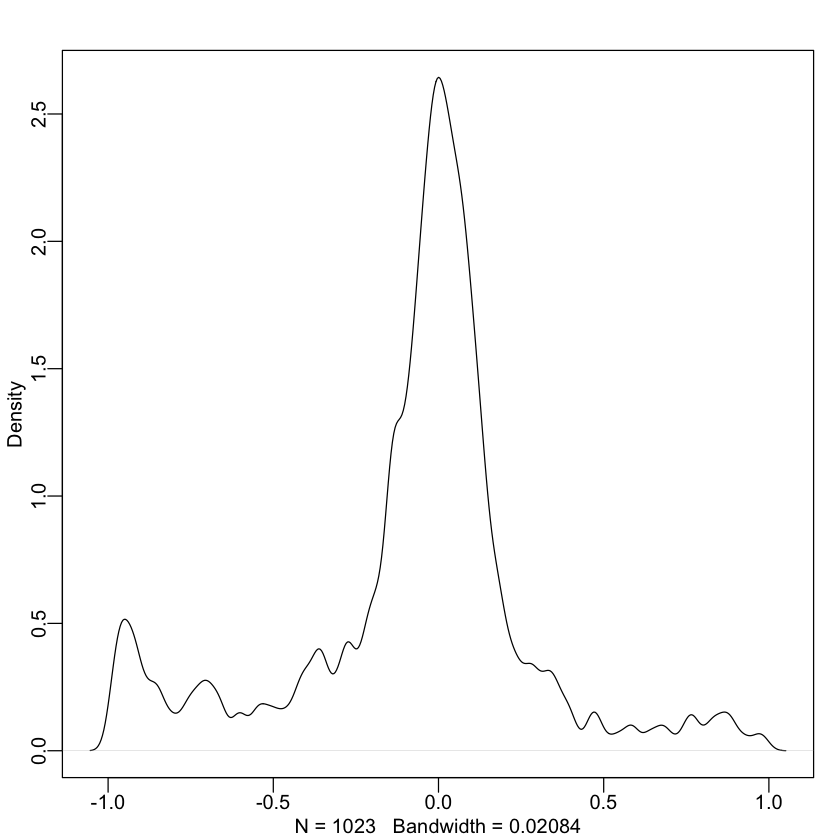

In [24]:
summary(df2$scoreCom)
dens(df2$scoreCom)

In [25]:
f5.2mST <- brm(
      formula = scoreCom.s ~ 1 + mentsRate.s + (1 + mentsRate.s | docauthorid),
      family = gaussian,
      prior = c(
          set_prior("normal(0,3)", class = "Intercept"), # gamma_00
          set_prior("normal(0,.5)", class = "b"), # coefficient max (range between -1 and 1)
          set_prior("exponential(1)", class = "sd"), # phi_0, phi_1, phi_2, phi_3
          set_prior("exponential(1)", class = "sigma"), # sigma
          set_prior("lkj(2)", class = "cor") # R
      ),
      data = df2, 
      chains=4, cores=4, iter=3000, warmup = 1000, seed = 4,
      control=list(adapt_delta=.99, max_treedepth=12),
      file = "20240814_PhD_DiaChkSenSTMentsST_02s"
)

print(f5.2mST)

Compiling Stan program...

Start sampling

Found more than one class "stanfit" in cache; using the first, from namespace 'rstan'

Also defined by ‘rethinking’

Found more than one class "stanfit" in cache; using the first, from namespace 'rstan'

Also defined by ‘rethinking’

Found more than one class "stanfit" in cache; using the first, from namespace 'rstan'

Also defined by ‘rethinking’

Found more than one class "stanfit" in cache; using the first, from namespace 'rstan'

Also defined by ‘rethinking’



 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scoreCom.s ~ 1 + mentsRate.s + (1 + mentsRate.s | docauthorid) 
   Data: df2 (Number of observations: 1023) 
  Draws: 4 chains, each with iter = 3000; warmup = 1000; thin = 1;
         total post-warmup draws = 8000

Multilevel Hyperparameters:
~docauthorid (Number of levels: 4) 
                           Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sd(Intercept)                  0.48      0.29     0.18     1.24 1.00     2387
sd(mentsRate.s)                0.08      0.09     0.00     0.33 1.00     2717
cor(Intercept,mentsRate.s)     0.00      0.44    -0.80     0.80 1.00     6185
                           Tail_ESS
sd(Intercept)                  3455
sd(mentsRate.s)                3492
cor(Intercept,mentsRate.s)     4882

Regression Coefficients:
            Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept       0.13      0.28    -0.44     0.69 1.00     2100     2413
mentsRate.s     0.00   

In [13]:
f5.2m <- brm(
      formula = scoreCom ~ 1 + mentsRate.s + (1 + mentsRate.s | docauthorid),
      family = gaussian,
      prior = c(
          set_prior("normal(0,3)", class = "Intercept"), # gamma_00
          set_prior("normal(0,.5)", class = "b"), # coefficient max (range between -1 and 1)
          set_prior("exponential(1)", class = "sd"), # phi_0, phi_1, phi_2, phi_3
          set_prior("exponential(1)", class = "sigma"), # sigma
          set_prior("lkj(2)", class = "cor") # R
      ),
      data = df2, 
      chains=4, cores=4, iter=3000, warmup = 1000, seed = 4,
      control=list(adapt_delta=.99, max_treedepth=12),
      file = "20240813_PhD_DiaChkSenMentsST_02s"
)

print(f5.2m)

Compiling Stan program...

Start sampling

Found more than one class "stanfit" in cache; using the first, from namespace 'rstan'

Also defined by ‘rethinking’

Found more than one class "stanfit" in cache; using the first, from namespace 'rstan'

Also defined by ‘rethinking’

Found more than one class "stanfit" in cache; using the first, from namespace 'rstan'

Also defined by ‘rethinking’

Found more than one class "stanfit" in cache; using the first, from namespace 'rstan'

Also defined by ‘rethinking’

Warning message:
“There were 2 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“There were 2 divergent transitions after warmup. Increasing adapt_delta above 0.99 may help. See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scoreCom ~ 1 + mentsRate.s + (1 + mentsRate.s | docauthorid) 
   Data: df2 (Number of observations: 1023) 
  Draws: 4 chains, each with iter = 3000; warmup = 1000; thin = 1;
         total post-warmup draws = 8000

Multilevel Hyperparameters:
~docauthorid (Number of levels: 4) 
                           Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sd(Intercept)                  0.20      0.15     0.07     0.62 1.00     2096
sd(mentsRate.s)                0.03      0.04     0.00     0.15 1.00     2833
cor(Intercept,mentsRate.s)     0.01      0.46    -0.81     0.82 1.00     6419
                           Tail_ESS
sd(Intercept)                  2440
sd(mentsRate.s)                3828
cor(Intercept,mentsRate.s)     4611

Regression Coefficients:
            Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept      -0.02      0.12    -0.26     0.24 1.00     2433     2670
mentsRate.s     0.00     

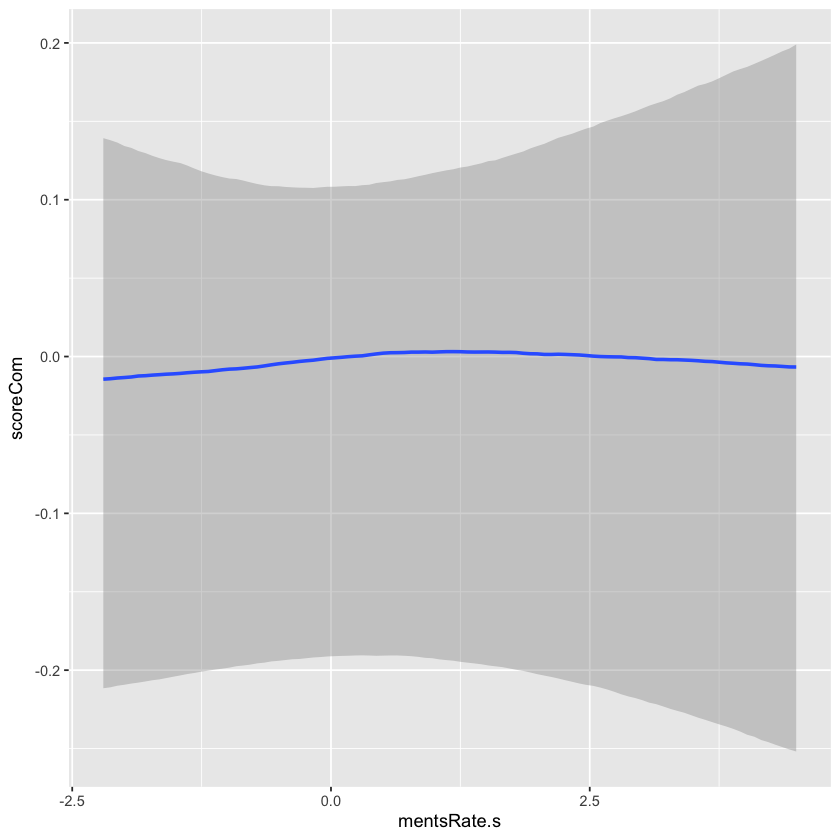

In [20]:
pme <- conditional_effects(f5.2m, prob=.90, re_formula=NULL) 
p1 <- plot(pme, plot = FALSE)[[1]]
p1

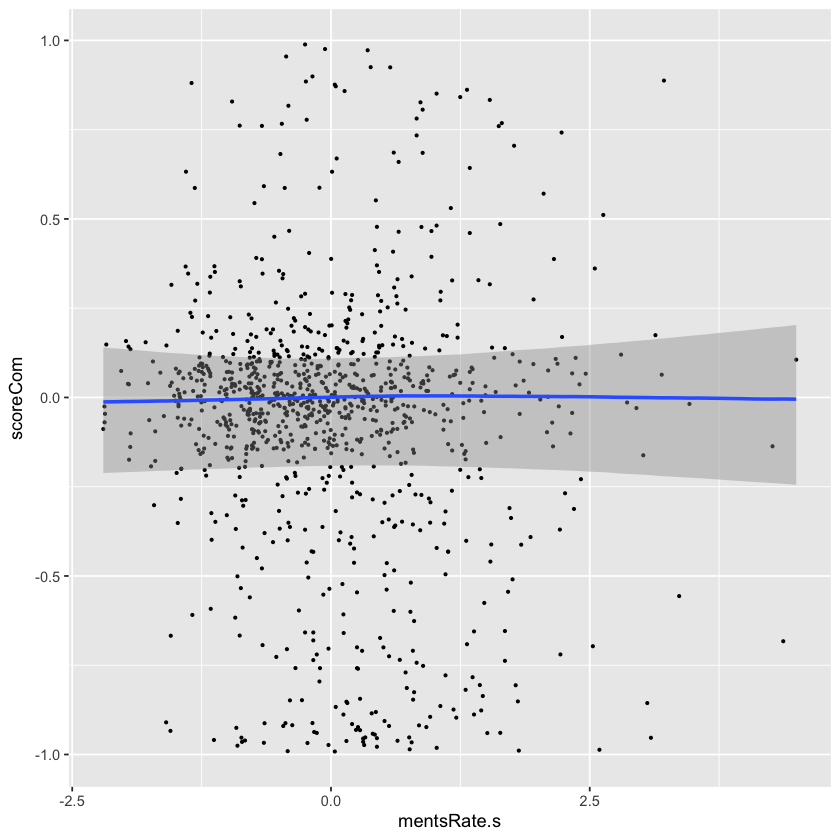

In [18]:
plot(conditional_effects(f5.2m, prob=.90, re_formula=NULL), points=T, point_args = list(size = .5))

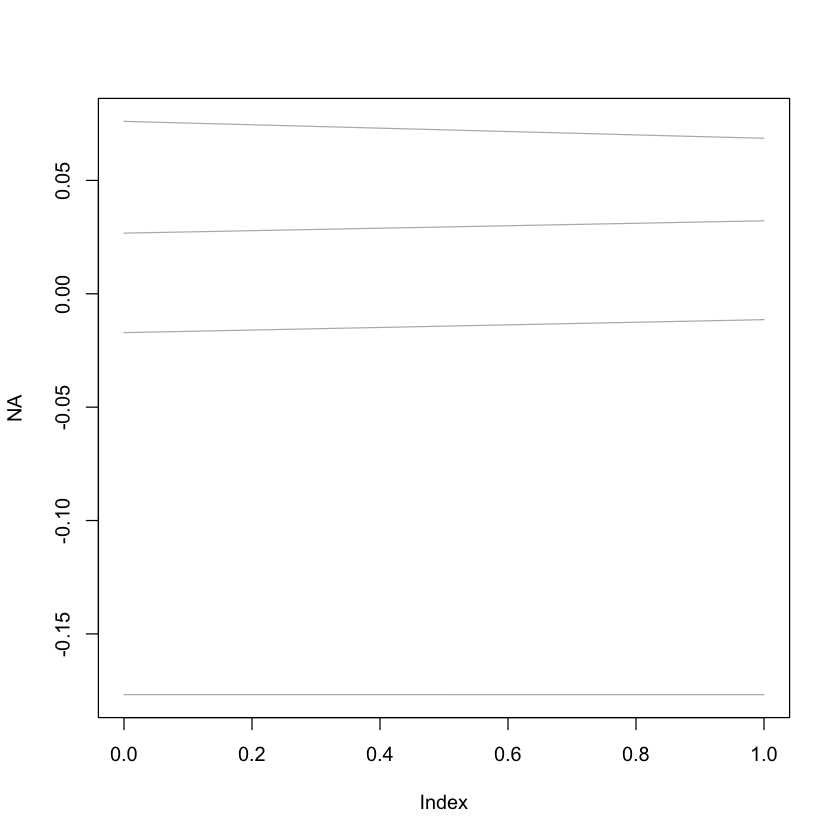

In [21]:
re2 <- ranef(f5.2m)
fe2 <- fixef(f5.2m)

# get the intercept for each student (random plus fixed effect)
a <- re2[[1]][,"Estimate","Intercept"] + fe2["Intercept","Estimate"]
# get the slope for each student (random plus fixed effect)
b <- re2[[1]][,"Estimate","mentsRate.s"] + fe2["mentsRate.s","Estimate"]

# take all writers
s <- sample(length(a),4)
# figure out a good vertical range
ylim <- range(a[s],(a+1*(b))[s])
# plot the individual lines
plot(NA,xlim=c(0,1),ylim=ylim)
for(i in s){
    lines(c(0,1),c(a[i],a[i] + 1*b[i]),col='#00000055')
}

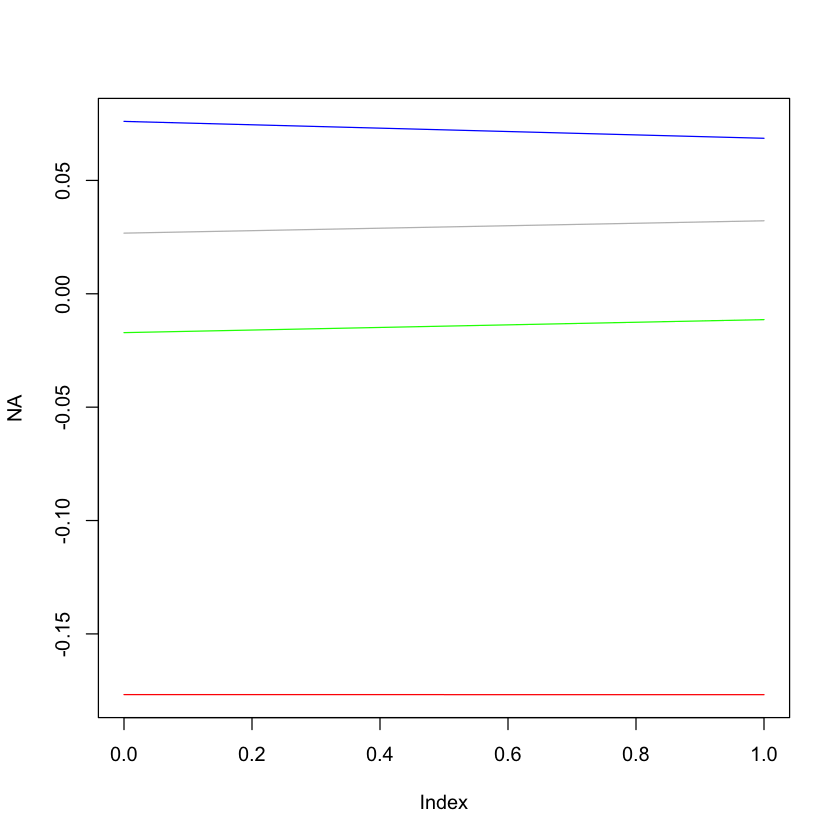

In [22]:
# Like above but with different colours

fixers <- data.frame(fe2)
randoms <- data.frame((re2)[1])

data1 <- randoms                                          
data1$row_names <- row.names(data1)
data1$row_names[data1$row_names=="D0002"] <- "Housewife"
data1$row_names[data1$row_names=="D0003"] <- "Labourer"
data1$row_names[data1$row_names=="D0007"] <- "Businessman"
data1$row_names[data1$row_names=="D0009"] <- "Lady"

aHW  <- data1$docauthorid.Estimate.Intercept[1] + fixers[1,1] #Housewife intercept
bHW  <- data1$docauthorid.Estimate.mentsRate.s[1] + fixers[2,1] #Housewife mentions rate

aBL  <- data1$docauthorid.Estimate.Intercept[2] + fixers[1,1] #Labourer intercept
bBL  <- data1$docauthorid.Estimate.mentsRate.s[2] + fixers[2,1] #Labourer mentions rate

aBM  <- data1$docauthorid.Estimate.Intercept[3] + fixers[1,1] #Businessman intercept
bBM  <- data1$docauthorid.Estimate.mentsRate.s[3] + fixers[2,1] #Businessman mentions rate

aGP  <- data1$docauthorid.Estimate.Intercept[4] + fixers[1,1] #Lady intercept
bGP <- data1$docauthorid.Estimate.mentsRate.s[4] + fixers[2,1] #Lady mentions rate

alphas <- c(aHW,aBL,aBM,aGP)
betas <- c(bHW,bBL,bBM,bGP)

plot(NA,xlim=c(0,1),ylim=ylim)
{lines(c(0,1),c(alphas[1],alphas[1] + 1*betas[1]),col='red')} # Housewife
{lines(c(0,1),c(alphas[2],alphas[2] + 1*betas[2]),col='blue')} # Labourer
{lines(c(0,1),c(alphas[3],alphas[3] + 1*betas[3]),col='green')} # Businessman
{lines(c(0,1),c(alphas[4],alphas[4] + 1*betas[4]),col='grey')} # Lady

#dev.copy(png,'20240811_PhD_DiaChkSentMent.png')
#dev.off()

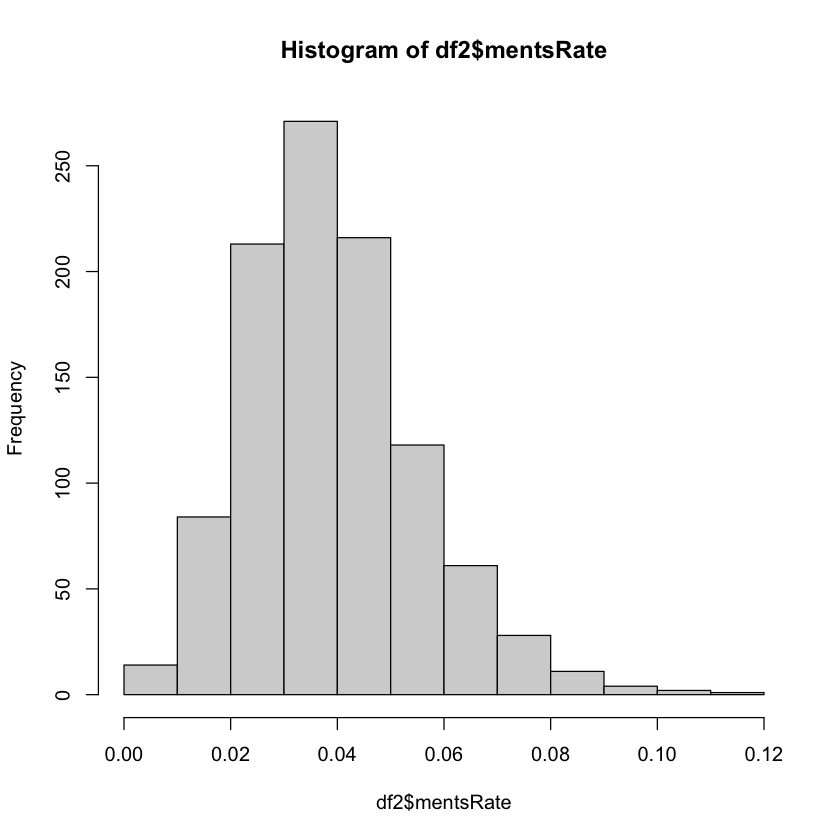

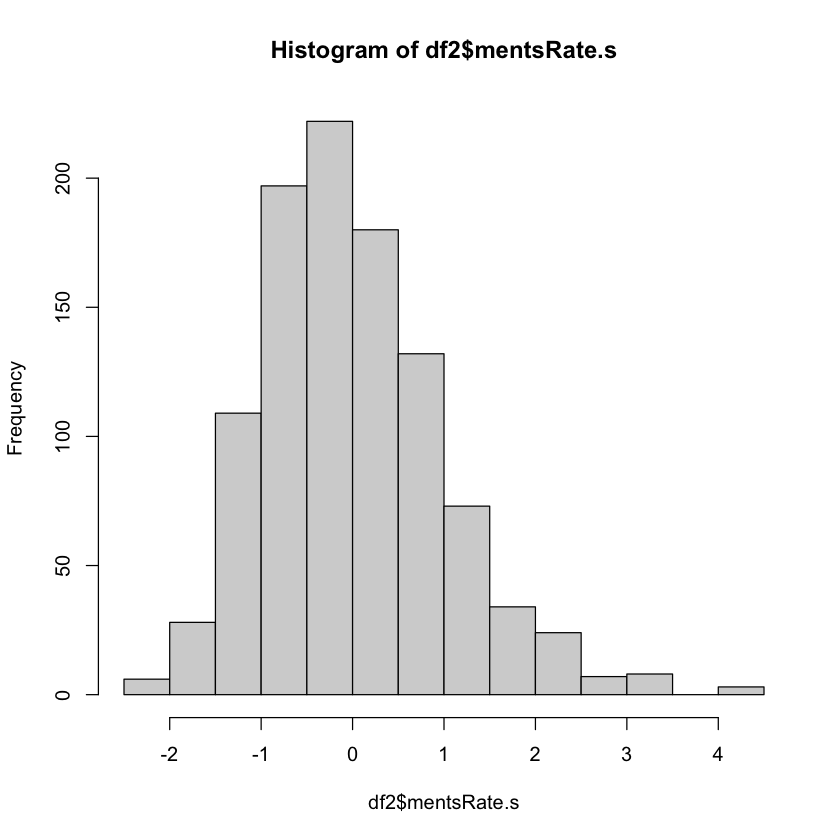

In [23]:
hist(df2$mentsRate)
hist(df2$mentsRate.s)

In [91]:
f6m <- readRDS("20240702_PhD_DiaChkSenFPP_02.rds")

In [22]:
f6m <- brm(
    formula= scoreCom ~ fppAllRate + (1 | docauthorid),
    family = 'gaussian',
    prior=c(
        set_prior("normal(0,3)",class="Intercept"),
        set_prior("normal(0,3)",class='b'),
        set_prior("uniform(0,10)",class="sd", ub = 10)
    ),
    data=df2,
    chains=4, cores=4, iter=2000, warmup = 1000, seed = 4,
    file = "20240702_PhD_DiaChkSenFPP_02",
    control=list(adapt_delta=.99)
)

print(f6m)

Compiling Stan program...

Start sampling

Warning message:
“There were 4 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“There were 4 divergent transitions after warmup. Increasing adapt_delta above 0.99 may help. See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scoreCom ~ fppAllRate + (1 | docauthorid) 
   Data: df2 (Number of observations: 1023) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Multilevel Hyperparameters:
~docauthorid (Number of levels: 4) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.24      0.22     0.07     0.86 1.01      560      647

Regression Coefficients:
           Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     -0.02      0.16    -0.34     0.28 1.01      867      777
fppAllRate    -0.63      0.82    -2.29     1.02 1.00     2740     2114

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.35      0.01     0.33     0.36 1.00     2271     2386

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measu

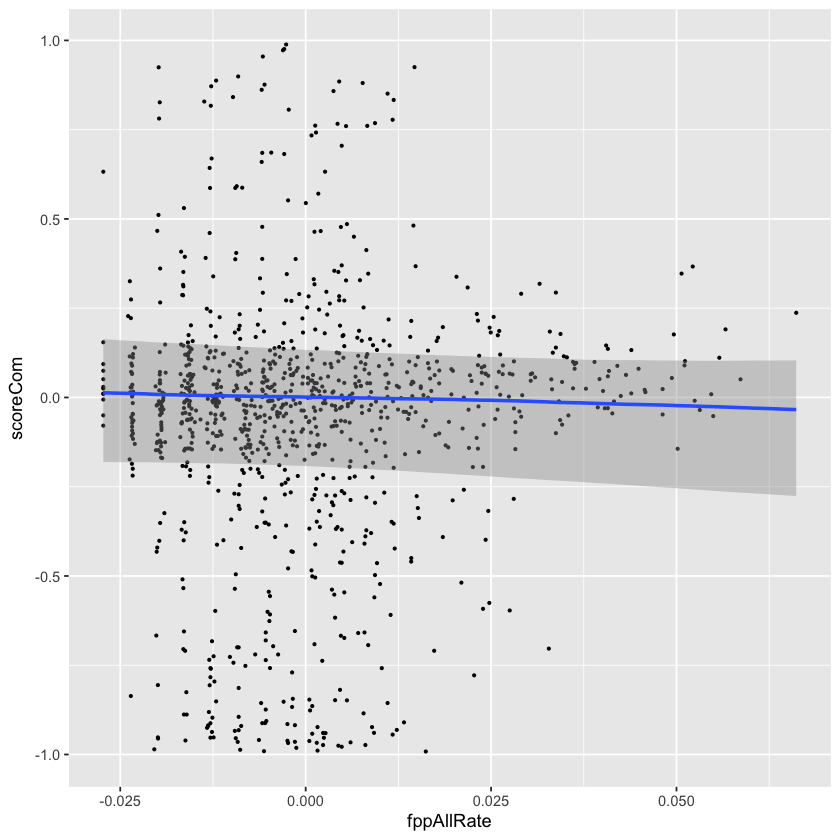

In [163]:
plot(conditional_effects(f6m, prob=.90, re_formula=NULL), points=T, point_args = list(size = .5))

In [24]:
f6ms <- brm(
      formula = scoreCom ~ 1 + fppAllRate + (1 + fppAllRate | docauthorid),
      family = gaussian,
      prior = c(
          set_prior("normal(0,3)", class = "Intercept"), # gamma_00
          set_prior("normal(0,.5)", class = "b"), # coefficient
          set_prior("exponential(1)", class = "sd"), # phi_0, phi_1, phi_2, phi_3
          set_prior("exponential(1)", class = "sigma"), # sigma
          set_prior("lkj(2)", class = "cor") # R
      ),
      data = df2, 
      chains = 4, cores = 4, iter = 2000, warmup = 1000, seed = 4,
      file = "20240813_PhD_DiaChkSenfppAll_02s",
      control=list(adapt_delta=.99)
)

print(f6ms)

Compiling Stan program...

Start sampling

Found more than one class "stanfit" in cache; using the first, from namespace 'rstan'

Also defined by ‘rethinking’

Found more than one class "stanfit" in cache; using the first, from namespace 'rstan'

Also defined by ‘rethinking’

Found more than one class "stanfit" in cache; using the first, from namespace 'rstan'

Also defined by ‘rethinking’

Found more than one class "stanfit" in cache; using the first, from namespace 'rstan'

Also defined by ‘rethinking’



 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scoreCom ~ 1 + fppAllRate + (1 + fppAllRate | docauthorid) 
   Data: df2 (Number of observations: 1023) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Multilevel Hyperparameters:
~docauthorid (Number of levels: 4) 
                          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sd(Intercept)                 0.21      0.17     0.06     0.67 1.01      889
sd(fppAllRate)                0.67      0.60     0.02     2.22 1.00     2873
cor(Intercept,fppAllRate)     0.05      0.44    -0.77     0.83 1.00     4210
                          Tail_ESS
sd(Intercept)                  936
sd(fppAllRate)                1874
cor(Intercept,fppAllRate)     2304

Regression Coefficients:
           Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     -0.02      0.14    -0.33     0.25 1.00      825      672
fppAllRate    -0.16      0.45    -1.0

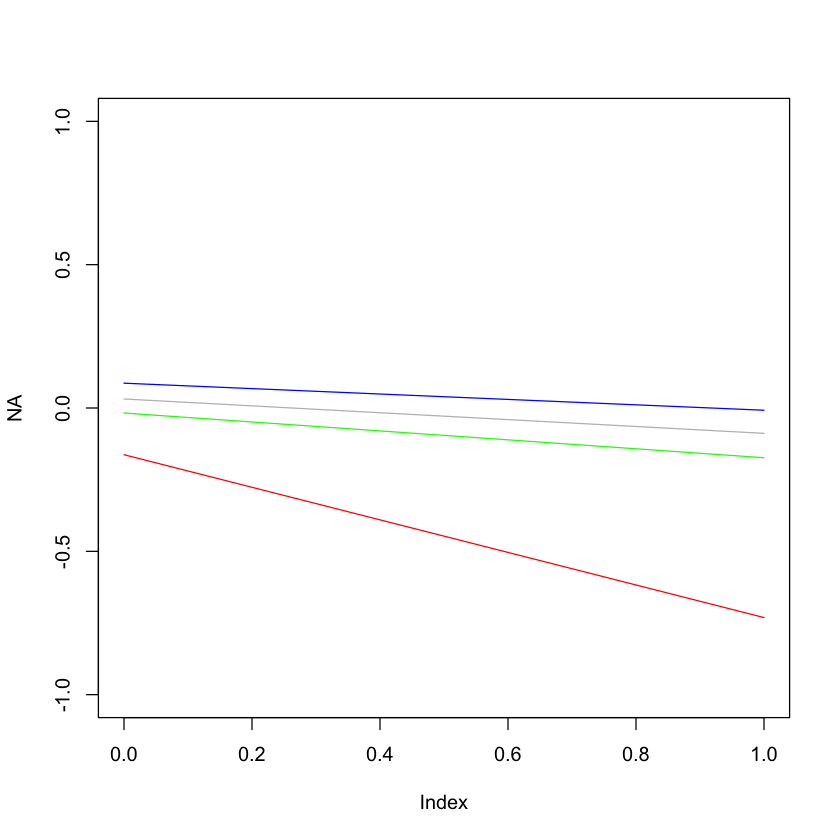

In [29]:
# Like above but with different colours

re2 <- ranef(f6ms)
fe2 <- fixef(f6ms)

fixers <- data.frame(fe2)
randoms <- data.frame((re2)[1])

data1 <- randoms                                          
data1$row_names <- row.names(data1)
data1$row_names[data1$row_names=="D0002"] <- "Housewife"
data1$row_names[data1$row_names=="D0003"] <- "Labourer"
data1$row_names[data1$row_names=="D0007"] <- "Businessman"
data1$row_names[data1$row_names=="D0009"] <- "Lady"

aHW  <- data1$docauthorid.Estimate.Intercept[1] + fixers[1,1] #Housewife intercept
bHW  <- data1$docauthorid.Estimate.fppAllRate[1] + fixers[2,1] #Housewife mentions rate

aBL  <- data1$docauthorid.Estimate.Intercept[2] + fixers[1,1] #Labourer intercept
bBL  <- data1$docauthorid.Estimate.fppAllRate[2] + fixers[2,1] #Labourer mentions rate

aBM  <- data1$docauthorid.Estimate.Intercept[3] + fixers[1,1] #Businessman intercept
bBM  <- data1$docauthorid.Estimate.fppAllRate[3] + fixers[2,1] #Businessman mentions rate

aGP  <- data1$docauthorid.Estimate.Intercept[4] + fixers[1,1] #Lady intercept
bGP <- data1$docauthorid.Estimate.fppAllRate[4] + fixers[2,1] #Lady mentions rate

alphas <- c(aHW,aBL,aBM,aGP)
betas <- c(bHW,bBL,bBM,bGP)

plot(NA,xlim=c(0,1),ylim=c(-1,1))
{lines(c(0,1),c(alphas[1],alphas[1] + 1*betas[1]),col='red')} # Housewife
{lines(c(0,1),c(alphas[2],alphas[2] + 1*betas[2]),col='blue')} # Labourer
{lines(c(0,1),c(alphas[3],alphas[3] + 1*betas[3]),col='green')} # Businessman
{lines(c(0,1),c(alphas[4],alphas[4] + 1*betas[4]),col='grey')} # Lady

#dev.copy(png,'20240813_PhD_DiaChkSentfppAll.png')
#dev.off()

In [152]:
#f6.1m <- readRDS("20240702_PhD_DiaSenChkFPPSub_02.rds")

Compiling Stan program...

Start sampling

Warning message:
“There were 1 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“There were 1 divergent transitions after warmup. Increasing adapt_delta above 0.99 may help. See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scoreCom ~ fppSubRate + (1 | docauthorid) 
   Data: df2 (Number of observations: 1023) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Multilevel Hyperparameters:
~docauthorid (Number of levels: 4) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.24      0.21     0.07     0.88 1.01      543      696

Regression Coefficients:
           Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     -0.01      0.15    -0.32     0.29 1.00      879      822
fppSubRate    -0.80      0.96    -2.74     1.03 1.00     2276     2330

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.35      0.01     0.33     0.36 1.00     2538     2190

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measu

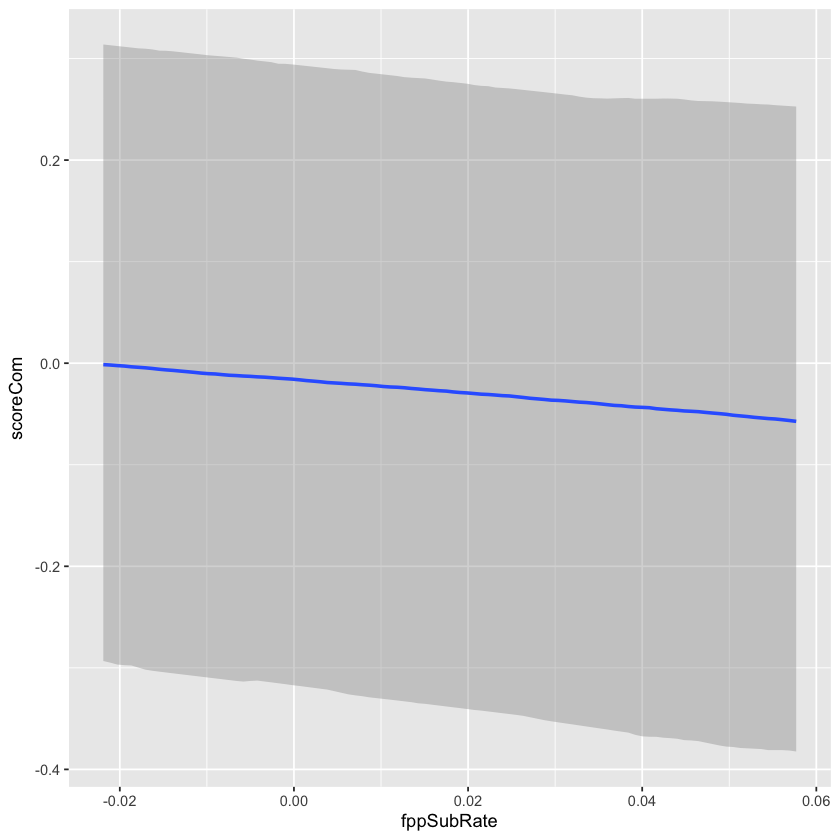

In [35]:
f6.1m <- brm(
    formula= scoreCom ~ fppSubRate + (1 | docauthorid),
    family = 'gaussian',
    prior=c(
        set_prior("normal(0,3)",class="Intercept"),
        set_prior("normal(0,3)",class='b'),
        set_prior("uniform(0,10)",class="sd", ub = 10)
    ),
    data=df2,
    chains=4, cores=4, iter=2000, warmup = 1000, seed = 4,
    file = "20240702_PhD_DiaSenChkFPPSub_02",
    control=list(adapt_delta=.99)
)

print(f6.1m)

conditional_effects(f6.1m)

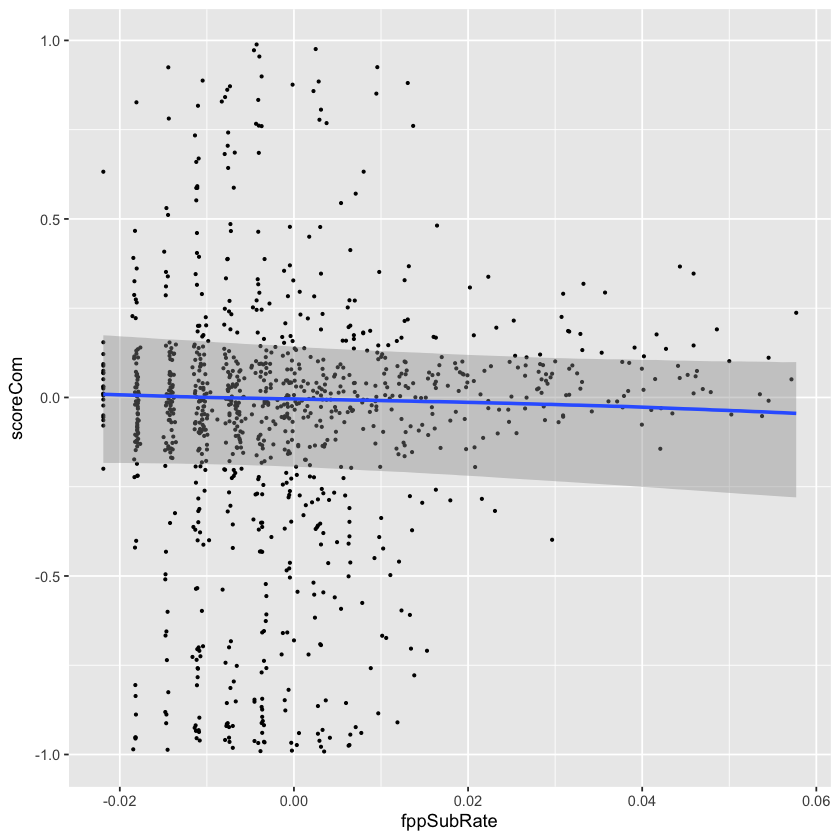

In [167]:
plot(conditional_effects(f6.1m, prob=.90, re_formula=NULL), points=T, point_args = list(size = .5))

In [26]:
f6.1ms <- brm(
      formula = scoreCom ~ 1 + fppSubRate + (1 + fppSubRate | docauthorid),
      family = gaussian,
      prior = c(
          set_prior("normal(0,3)", class = "Intercept"), # gamma_00
          set_prior("normal(0,.5)", class = "b"), # coefficient
          set_prior("exponential(1)", class = "sd"), # phi_0, phi_1, phi_2, phi_3
          set_prior("exponential(1)", class = "sigma"), # sigma
          set_prior("lkj(2)", class = "cor") # R
      ),
      data = df2, 
      chains = 4, cores = 4, iter = 2000, warmup = 1000, seed = 4,
      file = "20240813_PhD_DiaChkSenfppSub_02s",
      control=list(adapt_delta=.99)
)

print(f6.1ms)

Compiling Stan program...

Start sampling

Found more than one class "stanfit" in cache; using the first, from namespace 'rstan'

Also defined by ‘rethinking’

Found more than one class "stanfit" in cache; using the first, from namespace 'rstan'

Also defined by ‘rethinking’

Found more than one class "stanfit" in cache; using the first, from namespace 'rstan'

Also defined by ‘rethinking’

Found more than one class "stanfit" in cache; using the first, from namespace 'rstan'

Also defined by ‘rethinking’

Warning message:
“There were 1 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“There were 1 divergent transitions after warmup. Increasing adapt_delta above 0.99 may help. See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scoreCom ~ 1 + fppSubRate + (1 + fppSubRate | docauthorid) 
   Data: df2 (Number of observations: 1023) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Multilevel Hyperparameters:
~docauthorid (Number of levels: 4) 
                          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sd(Intercept)                 0.20      0.15     0.06     0.60 1.00     1008
sd(fppSubRate)                0.74      0.68     0.03     2.51 1.00     2895
cor(Intercept,fppSubRate)     0.06      0.44    -0.78     0.83 1.00     3731
                          Tail_ESS
sd(Intercept)                 1005
sd(fppSubRate)                1800
cor(Intercept,fppSubRate)     2498

Regression Coefficients:
           Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     -0.02      0.14    -0.26     0.24 1.00      969      832
fppSubRate    -0.16      0.47    -1.0

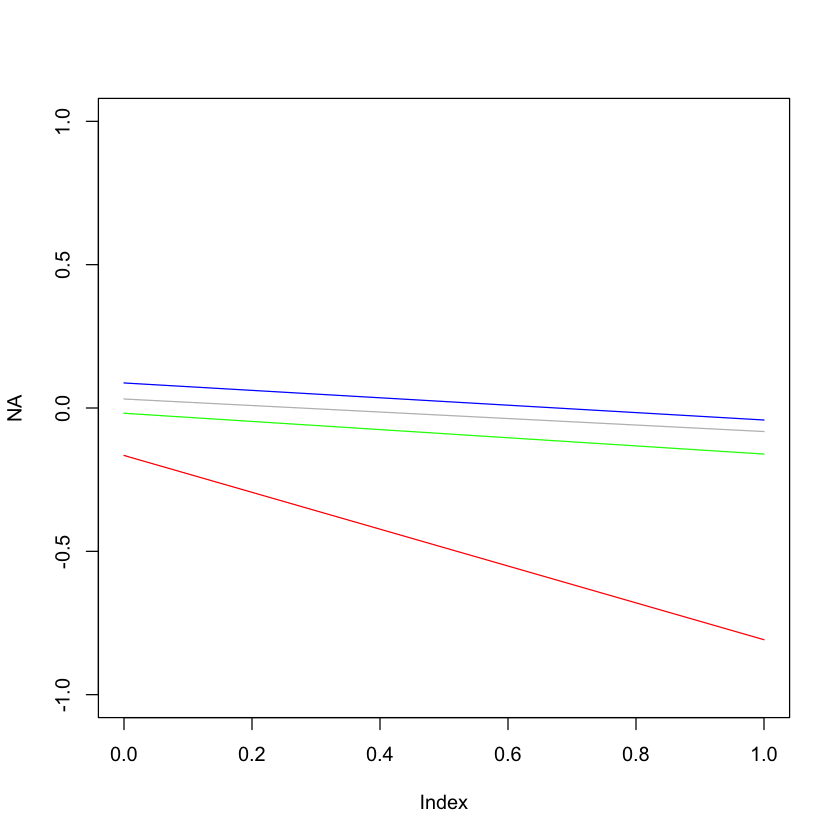

In [28]:
# Like above but with different colours

re2 <- ranef(f6.1ms)
fe2 <- fixef(f6.1ms)

fixers <- data.frame(fe2)
randoms <- data.frame((re2)[1])

data1 <- randoms                                          
data1$row_names <- row.names(data1)
data1$row_names[data1$row_names=="D0002"] <- "Housewife"
data1$row_names[data1$row_names=="D0003"] <- "Labourer"
data1$row_names[data1$row_names=="D0007"] <- "Businessman"
data1$row_names[data1$row_names=="D0009"] <- "Lady"

aHW  <- data1$docauthorid.Estimate.Intercept[1] + fixers[1,1] #Housewife intercept
bHW  <- data1$docauthorid.Estimate.fppSubRate[1] + fixers[2,1] #Housewife mentions rate

aBL  <- data1$docauthorid.Estimate.Intercept[2] + fixers[1,1] #Labourer intercept
bBL  <- data1$docauthorid.Estimate.fppSubRate[2] + fixers[2,1] #Labourer mentions rate

aBM  <- data1$docauthorid.Estimate.Intercept[3] + fixers[1,1] #Businessman intercept
bBM  <- data1$docauthorid.Estimate.fppSubRate[3] + fixers[2,1] #Businessman mentions rate

aGP  <- data1$docauthorid.Estimate.Intercept[4] + fixers[1,1] #Lady intercept
bGP <- data1$docauthorid.Estimate.fppSubRate[4] + fixers[2,1] #Lady mentions rate

alphas <- c(aHW,aBL,aBM,aGP)
betas <- c(bHW,bBL,bBM,bGP)

plot(NA,xlim=c(0,1),ylim=c(-1,1))
{lines(c(0,1),c(alphas[1],alphas[1] + 1*betas[1]),col='red')} # Housewife
{lines(c(0,1),c(alphas[2],alphas[2] + 1*betas[2]),col='blue')} # Labourer
{lines(c(0,1),c(alphas[3],alphas[3] + 1*betas[3]),col='green')} # Businessman
{lines(c(0,1),c(alphas[4],alphas[4] + 1*betas[4]),col='grey')} # Lady

#dev.copy(png,'20240813_PhD_DiaChkSentfppSub.png')
#dev.off()